# Denoising Diffusion Probabilistic Models

https://arxiv.org/abs/2006.11239 - Paper to replicate

## Define diffusion model

In [6]:
## Standard libraries
import os
import math
import numpy as np 
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
# Set Seaborn style
sns.set(style='darkgrid', font_scale=1.2)
from sklearn.datasets import make_moons

## Progress bar
from tqdm.notebook import tqdm

import torch
print("Using torch", torch.__version__)
#torch.manual_seed(42) # Setting the seed
import torch.nn as nn

Using torch 1.13.1


In [7]:
class Diffuser:
    def __init__(self, num_timesteps=200, beta_range=(0.0001, 0.02), reverse_noise=0.1, device='cuda'):
        self.device = device
        self.T = num_timesteps
        self.betas = torch.linspace(beta_range[0], beta_range[1], num_timesteps)
        self.sigma_t = reverse_noise
        self.set_constants()

    def set_constants(self):
        self.alphas = 1. - self.betas
        self.oneminus_alpha = 1. - self.alphas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_alpha_reciprocal = 1./ torch.sqrt(self.alphas)
        self.sqrt_1minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)

    def forwards_diffusion(self, x0, t):
        # 1. Sample from the standard gaussian --> mean = 0, var = I
        noise = torch.randn_like(x0)

        # 2. Multiply to change standard deviation --> mean = 0 var = (1-alpha_bar) * I
        sample = self.sqrt_1minus_alpha_bar[t] * noise

        # 3. Bias it to increase mean --> mean = sqrt(alpha_bar)*x0, var = (1-alpha_bar) * I
        sample += (self.sqrt_alpha_bar[t] * x0) # noise + mean

        return sample, noise
    
    def training_step(self, model, X, optimiser, loss_fn, current_epoch):
        total_loss = 0.0
        tqdm_obj = tqdm(X, desc=f'Epoch [{current_epoch}]', dynamic_ncols=True)

        for x0, _ in tqdm_obj: 
            t = torch.randint(1, self.T + 1, (1,)) # Sample a time
            x_t, noise = self.forwards_diffusion(x0, t) # Get noisy image at time t in the diffusion schedule

            # 1. Forward pass
            pred_noise = model(x_t, t)

            # 2. Calc loss as given in paper, (i.e. between real noisy sample, and parametised noisy sample)
            loss = loss_fn(noise, pred_noise)

            # 3. Optimiser zero-grad
            optimiser.zero_grad()

            # 4. Backpropagation
            loss.backward()

            # 5. Update -- gradient ascent
            optimiser.step() 

            total_loss += loss.item()
        
        # Returns an avg loss
        return total_loss / len(X)
    
    def reverse_diffusion(self, model, X_shape):
        
        # Sample an noisy x
        x_t = torch.randn(X_shape, device=self.device)

        # Reverse the diffusion process -- pass through all the latent spaces until we get back to x0
        for t in tqdm(range(self.T)):
            z = torch.randn_like(x_t) if t > 1 else torch.zeros_like(x_t)
            
            x_t = (
                self.sqrt_alpha_reciprocal * 
                   (x_t - (self.oneminus_alpha[self.T - t] / self.sqrt_1minus_alpha_bar[self.T - t]) * model(x_t)) +
                   self.sigma_t * z
                   )
            
        # Return x_0
        return x_t


In [8]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim, output_dim, num_timesteps, embed_dim=4, device='cuda'):
        super().__init__()
        self.device = device
        
        # 'Attach' a time onto our input data
        self.embedding = nn.Embedding(num_timesteps, embed_dim)

        # Layer stack
        self.layers = nn.Sequential(
            nn.Linear(input_dim + embed_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    
    def forward(self, X, t):
        # Apply embedding to 't'
        t_embedded = self.embedding(t)
        
        X = X.unsqueeze(0)  # Convert X from shape [1] to [1, 1]
        X_embedded = torch.cat([X, t_embedded], dim=1)  # Concatenate along dimension 1

        
        return self.layers(X_embedded)


## Visualising and generating

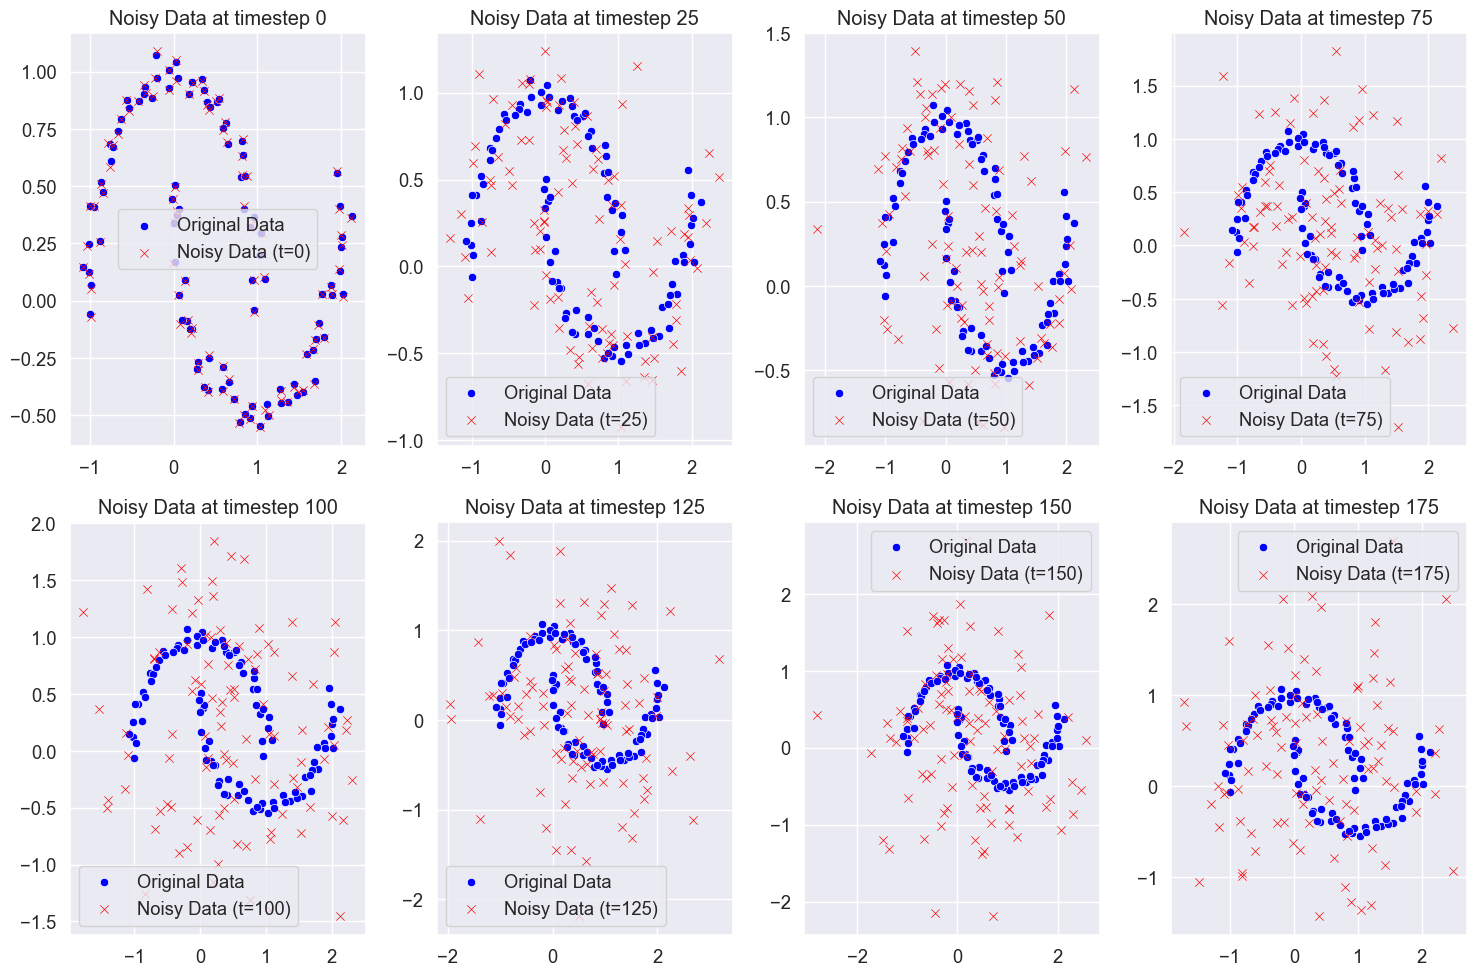

In [9]:
## Visualise a forwards diffusion

# Load the moons dataset
X, _ = make_moons(n_samples=100, noise=0.05, random_state=42)
X = torch.tensor(X)

# Create an instance of the diffusion model -- use defualt settings in this case
D = Diffuser()

# Calculate the number of rows and columns for subplots
plot_every = 25  # Plot every 10th timestep
num_timesteps = D.T
num_plots = num_timesteps // plot_every
num_cols = min(4, num_plots)  # Maximum of 2 columns
num_rows = (num_plots - 1) // num_cols + 1

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Sample noisy data points from the DDM at every 10th timestep and create subplots
for t in range(num_timesteps):
    if t % plot_every == 0:  # Plot every 10th timestep
        noisy_data, _ = D.forwards_diffusion(X, t)
        plot_num = t // plot_every
        row = plot_num // num_cols
        col = plot_num % num_cols

        # Scatter plots using Seaborn
        sns.scatterplot(x=X[:, 0], y=X[:, 1], color='blue', marker='o', label='Original Data', ax=axs[row, col])
        sns.scatterplot(x=noisy_data[:, 0].cpu().numpy(), y=noisy_data[:, 1].cpu().numpy(),
                        color='red', marker='x', label=f'Noisy Data (t={t})', ax=axs[row, col])
        
        axs[row, col].set_title(f'Noisy Data at timestep {t}')
        axs[row, col].legend()

plt.tight_layout()
plt.show()

Epoch [1]:   0%|          | 0/100 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x5 and 6x64)

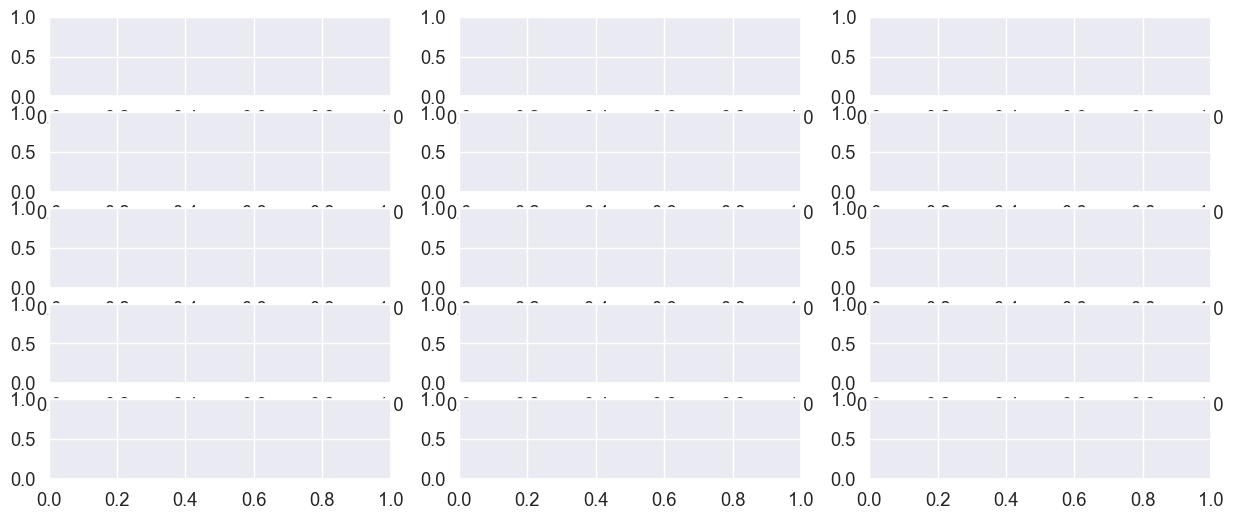

In [10]:
## Training and sampling

NUM_EPOCHS=10
LR=0.001 
TIMESTEPS=50 
shape = 1
net = NeuralNet(input_dim=2, output_dim=2, num_timesteps = D.T)
optimiser = torch.optim.Adam(net.parameters(), lr=LR, amsgrad=True)
loss_function = nn.MSELoss()

# Create a new figure and axis for subplots
num_rows=5
num_cols=3
sample_every = 2  # Sample every 10th epoch
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 6))

for epoch in range(1, NUM_EPOCHS+1):
        avg_loss= D.training_step(model=net, 
                                  X=X, 
                                  optimiser=optimiser,
                                  loss_fn=loss_function,
                                  current_epoch=epoch)
        
        if epoch % sample_every == 0:
                with torch.no_grad():
                        # Sample from p(x_t) -> reverse diffuse
                        x0 = D.reverse_diffusion(model=net, X_shape=2)
                        
                        plot_num = epoch // sample_every
                        row = plot_num // num_cols
                        col = plot_num % num_cols

                        # Plot x0 on the specified subplot
                        axs[row, col].plot(x0, label=f'Epoch {epoch}')
                
# Adjust layout and show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()